## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import seaborn as sns

# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [5]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [6]:
print("encounter_id", df["encounter_id"].nunique())
print("patient_nbr", df["patient_nbr"].nunique())

print("primary_diagnosis_code", df.primary_diagnosis_code.nunique())
print("rows", df.shape[0])

encounter_id 101766
patient_nbr 71518
primary_diagnosis_code 717
rows 143424


In [7]:
# there are more records than the number of encounters, therefore the dataset is at line level

In [8]:
null_df = df.copy()
null_df = null_df.replace('?', np.nan).replace('None', np.nan)
null_series = null_df.isnull().mean().sort_values(ascending=False)
null_series[null_series != 0]

weight                    0.970005
max_glu_serum             0.951089
A1Cresult                 0.820295
medical_specialty         0.484319
payer_code                0.377831
ndc_code                  0.163585
race                      0.023071
primary_diagnosis_code    0.000230
dtype: float64

In [9]:
# The columns weight, max_glu_serum, A1Cresult, medical_specialty, payer_code and ndc_code have a high amount of missing or zero values.



/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

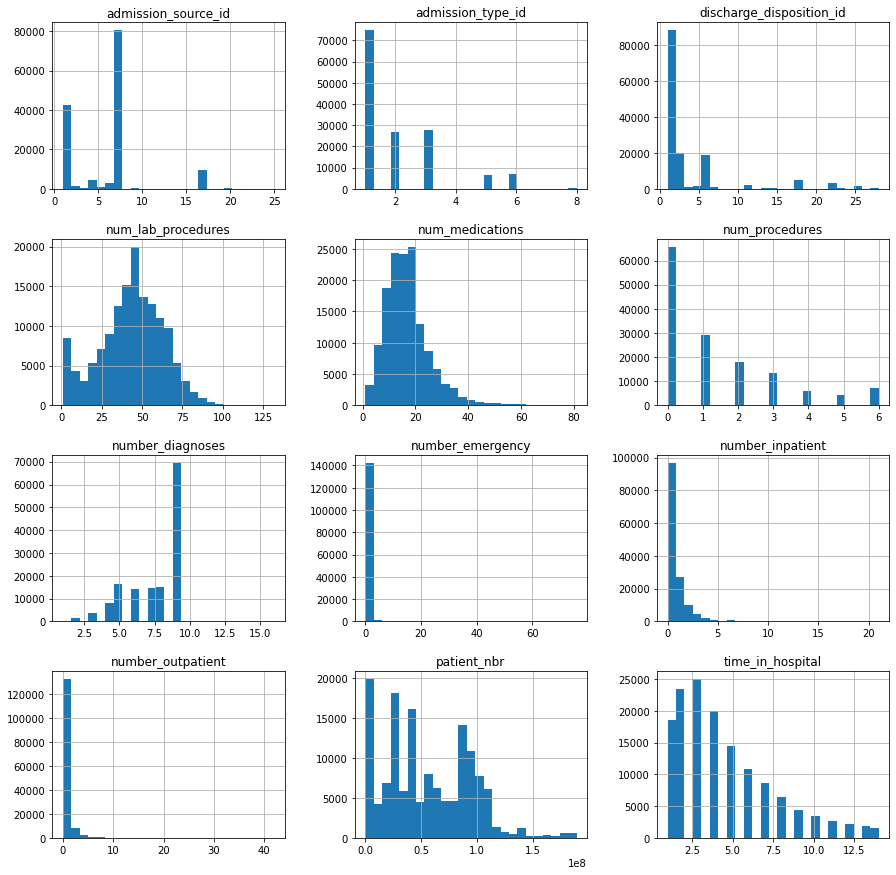

In [10]:
gauss_df = df.copy()
del gauss_df["encounter_id"]

gauss_df.hist(figsize=(15,15), bins=25)
plt.show()

In [11]:
# The features with a gaussian distribution are num_medications, num_lab_procedures and time_in_hospital.

In [12]:
# get the categorical columns
cat_col = list(df.select_dtypes(['object']).columns)
cat_col = cat_col + ['admission_type_id','discharge_disposition_id', 'admission_source_id']

cat_df = df[cat_col]
cat_df.nunique().sort_values(ascending=False)

other_diagnosis_codes       19374
primary_diagnosis_code        717
ndc_code                      251
medical_specialty              73
discharge_disposition_id       26
payer_code                     18
admission_source_id            17
weight                         10
age                            10
admission_type_id               8
race                            6
A1Cresult                       4
max_glu_serum                   4
readmitted                      3
gender                          3
change                          2
dtype: int64

In [13]:
# other_diagnosis_codes: 19374
# primary_diagnosis_code: 716
# ndc_code: 251

In [14]:
df['gender'].unique()


array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [15]:
df['race'].unique()

array(['Caucasian', 'AfricanAmerican', '?', 'Other', 'Asian', 'Hispanic'],
      dtype=object)

In [16]:
df['age'].unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

In [17]:
# get ride of '?' in race and 'Unknown/Invalid' for gender 

# filter "unkown" so we have only patients with a valid gender value left
print("Before:", df.shape[0])

is_valid = df['gender'] != "Unknown/Invalid"
df = df[is_valid]

print("After:", df.shape[0])


print("Before:", df.shape[0])

is_valid = df['race'] != "?"
df = df[is_valid]

print("After:", df.shape[0])



Before: 143424
After: 143419
Before: 143419
After: 140113


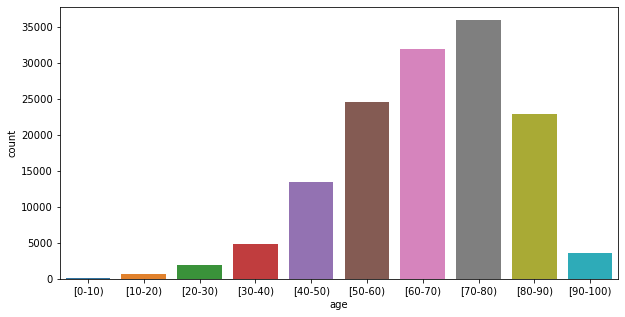

In [18]:
plt.figure(figsize=(10, 5))
p = sns.countplot(x='age', data=df)

In [19]:
df_age = pd.DataFrame([], columns = ['# Patiens']) 
df_age["# Patiens"] = df['age'].value_counts()
df_age["% Patiens"] = df['age'].value_counts(normalize=True)

df_age

,# Patiens,% Patiens
[70-80),36002,0.256950
[60-70),31999,0.228380
[50-60),24567,0.175337
[80-90),22986,0.164053
[40-50),13423,0.095801
[30-40),4848,0.034601
[90-100),3530,0.025194
[20-30),1874,0.013375
[10-20),724,0.005167
[0-10),160,0.001142


In [20]:
df_gender = pd.DataFrame([], columns = ['# Patiens']) 
df_gender["# Patiens"] = df['gender'].value_counts()
df_gender["% Patiens"] = df['gender'].value_counts(normalize=True)

df_gender

,# Patiens,% Patiens
Female,74548,0.532056
Male,65565,0.467944


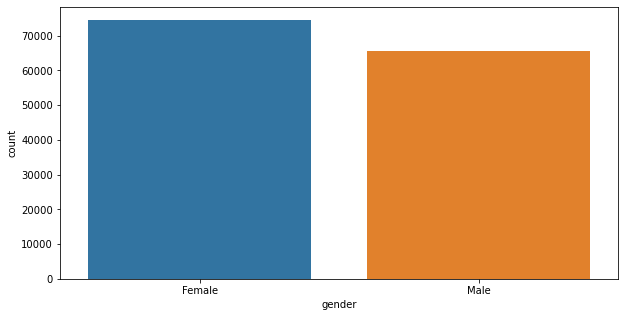

In [21]:
plt.figure(figsize=(10, 5))
sns.countplot(x='gender', data=df);

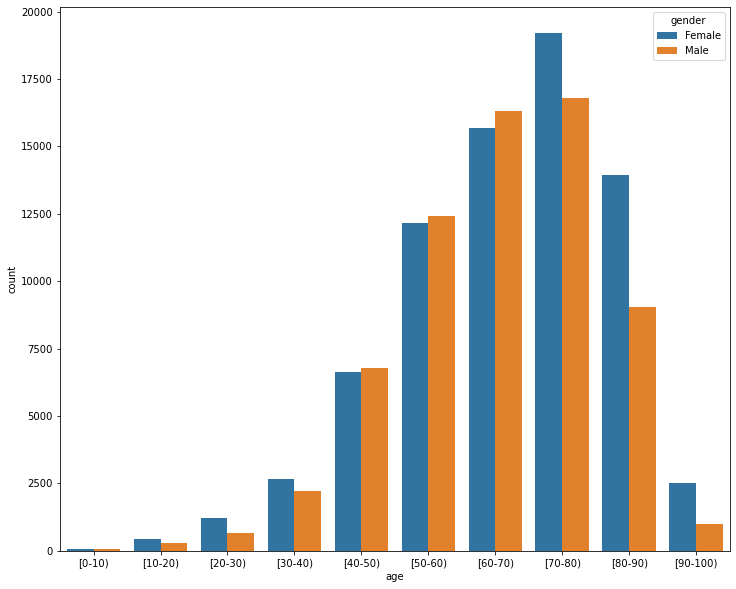

In [22]:

# distribution across both age and gender
plt.figure(figsize=(12, 10))
sns.countplot(x="age", hue="gender", data=df);

In [23]:
# Most of the patients are between the age group of 40-90. 
# Maximum count is 36002 (26%) for the age group 70-80
# There are more female than male patients (53% vs. 47%)
# Until 60 there are an equal amount of male and female patients per age group with a slightly higher number of male patients. After the age of 60 however there are always more female patients

In [24]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [25]:
ndc_code_df.head(1)

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [26]:
def reduce_dimension_ndc(df, ndc_df):
    '''
    df: pandas dataframe, input dataset
    ndc_df: pandas dataframe, drug code dataset used for mapping in generic names
    return:
        df: pandas dataframe, output dataframe with joined generic drug name
    '''
    return_df = df.copy()
    return_df = return_df.merge(
        ndc_df[['NDC_Code', 'Proprietary Name']], left_on='ndc_code', right_on='NDC_Code')
    return_df['generic_drug_name'] = return_df['Proprietary Name']
    del return_df["NDC_Code"]
    del return_df["Proprietary Name"]
    return return_df

In [27]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)
reduce_dim_df.head(1)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Novolin R


In [28]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [29]:
def select_first_encounter(df):
    '''
    df: pandas dataframe, dataframe with all encounters
    return:
        - first_encounter_df: pandas dataframe, dataframe with only the first encounter for a given patient
    '''
    ## sort the df by encouter_id (lowest encouter_id is first)
    df.sort_values('encounter_id')
    ## get the first encouter for each patient
    first_encounter_value = df.groupby('patient_nbr')['encounter_id'].head(1).values
    ## return the filtered df with the first encouter for each patient
    return df[df['encounter_id'].isin(first_encounter_value)]

In [30]:
first_encounter_df = select_first_encounter(reduce_dim_df)

In [31]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:54604
Number of unique encounters:54604
Tests passed!!


In [32]:
first_encounter_df.head(1)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Novolin R


In [57]:
def aggregate_dataset(df, grouping_fields, drug_column):
    # Aggregate the drug information
    agg_df = df.groupby(grouping_fields).apply(
        lambda x: pd.Series({
            'generic_drug_name_array': '|'.join(x[drug_column].dropna())
        })
    ).reset_index()

    # Pivot the drug information to wide format
    drugs_df = df.groupby(grouping_fields).apply(
        lambda x: pd.Series({
            **{drug: int(drug in x[drug_column].values) for drug in ndc_col_list}
        })
    ).reset_index()

    # Merge aggregated drug information with other columns
    agg_drug_df = pd.merge(agg_df, drugs_df, on=grouping_fields, how='left')

    # Ensure that payer_code and weight are included in the final DataFrame
    if 'payer_code' in df.columns:
        payer_code_df = df.groupby(grouping_fields)['payer_code'].first().reset_index()
        agg_drug_df = pd.merge(agg_drug_df, payer_code_df, on=grouping_fields, how='left')

    if 'weight' in df.columns:
        weight_df = df.groupby(grouping_fields)['weight'].mean().reset_index()
        agg_drug_df = pd.merge(agg_drug_df, weight_df, on=grouping_fields, how='left')

    return agg_drug_df, ndc_col_list


In [72]:
# Verify columns
print("Columns in agg_drug_df after aggregation:", agg_drug_df.columns)



Columns in agg_drug_df after aggregation: Index(['patient_nbr', 'encounter_id', 'generic_drug_name_array', 'Acarbose',
       'Afrezza', 'Amaryl', 'Avandia_2MG', 'Avandia_4MG', 'Duetact',
       'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glucophage', 'Glucophage_XR',
       'Glucotrol', 'Glucotrol_XL', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Glynase', 'Glyset', 'Humulin_R',
       'Metformin_Hcl', 'Metformin_Hydrochloride',
       'Metformin_Hydrochloride_Extended_Release', 'Miglitol', 'Nateglinide',
       'Novolin_R', 'Pioglitazole_And_Metformin_Hydrochloride', 'Pioglitazone',
       'Pioglitazone_Hydrochloride_And_Glimepiride', 'Prandin', 'Repaglinide',
       'Riomet', 'Riomet_Er', 'Starlix', 'Tolazamide', 'Tolbutamide',
       'payer_code', 'weight'],
      dtype='object')


In [73]:
print("Payer Code Distribution:")
print(agg_drug_df['payer_code'].value_counts())
print("Missing Payer Code Values:")
print(agg_drug_df['payer_code'].isna().sum())

Payer Code Distribution:
?     22627
MC    16428
HM     3018
BC     2613
SP     2555
MD     1814
CP     1470
UN     1424
CM     1144
OG      563
PO      369
DM      293
WC       92
CH       87
OT       51
MP       31
SI       25
Name: payer_code, dtype: int64
Missing Payer Code Values:
0


In [74]:
print("Weight Distribution:")
print(agg_drug_df['weight'].describe())
print("Missing Weight Values:")
print(agg_drug_df['weight'].isna().sum())

Weight Distribution:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: weight, dtype: float64
Missing Weight Values:
54604


In [75]:
# Categorical Features
categorical_features = [
    'gender',       # Required demographic feature
    'age',          # Required demographic feature
    'race'          # Required demographic feature
]

# Numerical Features
# Excluded: weight (completely missing)
# Exclude: payer_code (due to the high proportion of unknown values)

# Drug Features
drug_features = [
    'Acarbose', 'Afrezza', 'Amaryl', 'Avandia_2MG', 'Avandia_4MG', 'Duetact',
    'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hcl',
    'Glipizide_And_Metformin_Hydrochloride', 'Glucophage', 'Glucophage_XR',
    'Glucotrol', 'Glucotrol_XL', 'Glyburide',
    'Glyburide_And_Metformin_Hydrochloride',
    'Glyburide-metformin_Hydrochloride', 'Glynase', 'Glyset', 'Humulin_R',
    'Metformin_Hcl', 'Metformin_Hydrochloride',
    'Metformin_Hydrochloride_Extended_Release', 'Miglitol', 'Nateglinide',
    'Novolin_R', 'Pioglitazole_And_Metformin_Hydrochloride', 'Pioglitazone',
    'Pioglitazone_Hydrochloride_And_Glimepiride', 'Prandin', 'Repaglinide',
    'Riomet', 'Riomet_Er', 'Starlix', 'Tolazamide', 'Tolbutamide'
]

# Combine into a final feature list
selected_features = categorical_features + drug_features

print("Selected Features:")
print(selected_features)

Selected Features:
['gender', 'age', 'race', 'Acarbose', 'Afrezza', 'Amaryl', 'Avandia_2MG', 'Avandia_4MG', 'Duetact', 'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hcl', 'Glipizide_And_Metformin_Hydrochloride', 'Glucophage', 'Glucophage_XR', 'Glucotrol', 'Glucotrol_XL', 'Glyburide', 'Glyburide_And_Metformin_Hydrochloride', 'Glyburide-metformin_Hydrochloride', 'Glynase', 'Glyset', 'Humulin_R', 'Metformin_Hcl', 'Metformin_Hydrochloride', 'Metformin_Hydrochloride_Extended_Release', 'Miglitol', 'Nateglinide', 'Novolin_R', 'Pioglitazole_And_Metformin_Hydrochloride', 'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride', 'Prandin', 'Repaglinide', 'Riomet', 'Riomet_Er', 'Starlix', 'Tolazamide', 'Tolbutamide']


In [78]:
# Ensure correct data types
def cast_and_impute(df):
    # Cast columns to appropriate data types
    df = df.copy()

    # Cast categorical columns to 'category' type
    cat_columns = df.select_dtypes(include=['object']).columns
    for col in cat_columns:
        df[col] = df[col].astype('category')

    # Cast numerical columns to 'float' (or 'int' if appropriate)
    num_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[num_columns] = df[num_columns].astype('float')  # Cast numerical columns to float for imputation

    # Impute missing values for numerical features with zero
    df[num_columns] = df[num_columns].fillna(0)

    return df

# Apply the casting and imputation
first_encounter_df = cast_and_impute(first_encounter_df)

# Verify data types and missing values
print("Data types after casting:")
print(first_encounter_df.dtypes)

print("Missing values count:")
print(first_encounter_df.isnull().sum().sort_values(ascending=False))

from sklearn.model_selection import train_test_split

def split_data(df, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42):
    """
    Splits the dataset into train, validation, and test sets ensuring that a patient's data does not leak across partitions.

    Args:
    df (pd.DataFrame): The input dataframe.
    train_size (float): Proportion of data to be used for training.
    val_size (float): Proportion of data to be used for validation.
    test_size (float): Proportion of data to be used for testing.
    random_state (int): Seed for random number generator.

    Returns:
    tuple: Three DataFrames (train_df, val_df, test_df)
    """

    # Get unique patients
    unique_patients = df['patient_nbr'].unique()
    
    # Split patients into train and test sets
    train_patients, temp_patients = train_test_split(unique_patients, 
                                                    train_size=train_size, 
                                                    random_state=random_state, 
                                                    shuffle=True)
    
    # Split remaining patients into validation and test sets
    val_patients, test_patients = train_test_split(temp_patients, 
                                                  test_size=test_size / (val_size + test_size), 
                                                  random_state=random_state, 
                                                  shuffle=True)
    
    # Create train, validation, and test sets based on patients
    train_df = df[df['patient_nbr'].isin(train_patients)]
    val_df = df[df['patient_nbr'].isin(val_patients)]
    test_df = df[df['patient_nbr'].isin(test_patients)]
    
    # Verify that patients are not leaking across partitions
    assert len(set(train_df['patient_nbr']).intersection(val_df['patient_nbr'])) == 0
    assert len(set(train_df['patient_nbr']).intersection(test_df['patient_nbr'])) == 0
    assert len(set(val_df['patient_nbr']).intersection(test_df['patient_nbr'])) == 0
    
    # Verify that the number of unique patients and rows is consistent
    total_patients = len(unique_patients)
    assert len(train_df['patient_nbr'].unique()) + len(val_df['patient_nbr'].unique()) + len(test_df['patient_nbr'].unique()) == total_patients
    assert len(df) == len(train_df) + len(val_df) + len(test_df)
    
    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")
    
    return train_df, val_df, test_df

# Apply the split
train_df, val_df, test_df = split_data(first_encounter_df)

# Sample output
print("Sample training data:")
print(train_df.head())

print("Sample validation data:")
print(val_df.head())

print("Sample testing data:")
print(test_df.head())


Data types after casting:
encounter_id                 float64
patient_nbr                  float64
race                        category
gender                      category
age                         category
weight                       float64
admission_type_id            float64
discharge_disposition_id     float64
admission_source_id          float64
time_in_hospital             float64
payer_code                  category
medical_specialty           category
primary_diagnosis_code      category
other_diagnosis_codes       category
number_outpatient            float64
number_inpatient             float64
number_emergency             float64
num_lab_procedures           float64
number_diagnoses             float64
num_medications              float64
num_procedures               float64
ndc_code                    category
max_glu_serum               category
A1Cresult                   category
change                      category
readmitted                  category
generic_drug

Visualizing Training Set...
age       gender  race           
[0-10)    Female  AfricanAmerican      3
                  Asian                1
                  Caucasian           30
                  Hispanic             0
                  Other                0
                                    ... 
[90-100)  Male    AfricanAmerican     36
                  Asian                1
                  Caucasian          322
                  Hispanic             2
                  Other                5
Length: 100, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)
Visualizing Validation Set...
age       gender  race           
[0-10)    Female  AfricanAmerican      3
                  Asian                0
                  Caucasian           18
                  Hispanic             1
                  Other                0
                                    ... 
[90-100)  Male    AfricanAmerican      7
                  Asian                1
                  Caucasian     

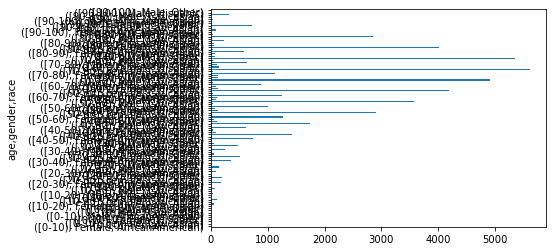

In [80]:
# Function to visualize distributions of key features
def visualize_distributions(df, group_columns, title_prefix=""):
    """
    Visualizes the distribution of key features across the DataFrame.

    Args:
    df (pandas.DataFrame): DataFrame to visualize.
    group_columns (list): List of columns to group and visualize.
    title_prefix (str): Prefix for the plot titles.
    """
    # Call show_group_stats_viz directly with the correct parameters
    show_group_stats_viz(df, group_columns)

# Define the key features/groups to analyze
key_features = ['age', 'gender', 'race']

# List of dataframes and their names to visualize
dfs = [train_df, val_df, test_df]
df_names = ['Training Set', 'Validation Set', 'Test Set']

# Visualize distributions for each partition
for df, name in zip(dfs, df_names):
    print(f"Visualizing {name}...")
    visualize_distributions(df, key_features, title_prefix=name)



### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_group_stats_viz(df, key_features):
    """
    Visualizes the distribution of a key_features across different groups.

    Args:
    df (pandas.DataFrame): DataFrame to visualize.
    key_features (str): The field to visualize.
    """
    plt.figure(figsize=(12, 6))
    
    # Create a countplot to visualize the distribution of the predictor field
    sns.countplot(data=df, x=key_features, palette='viridis')
    
    plt.title(f'Distribution of {key_features}')
    plt.xlabel(key_features)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Visualizing Training Set...
Visualizing distribution for age...


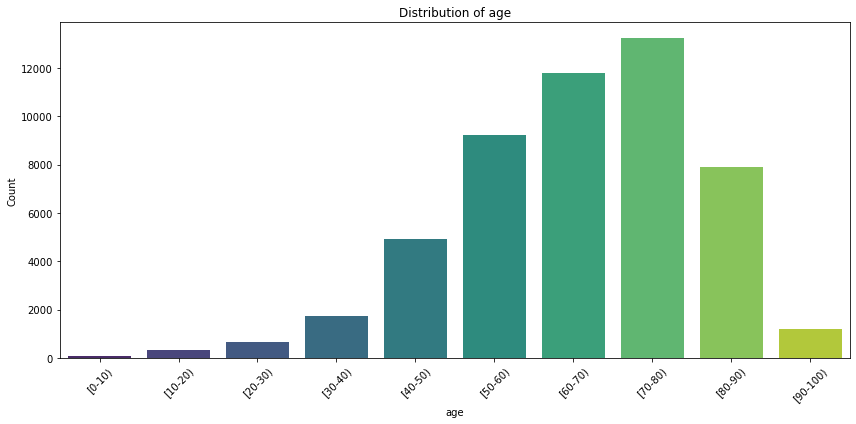

Visualizing distribution for gender...


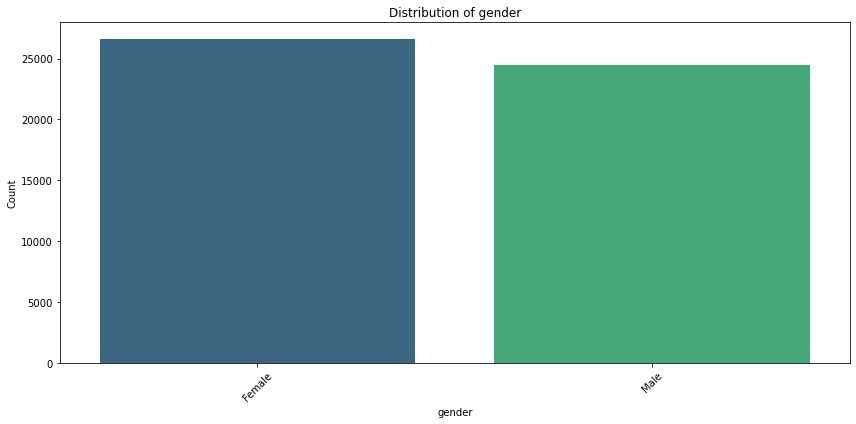

Visualizing distribution for race...


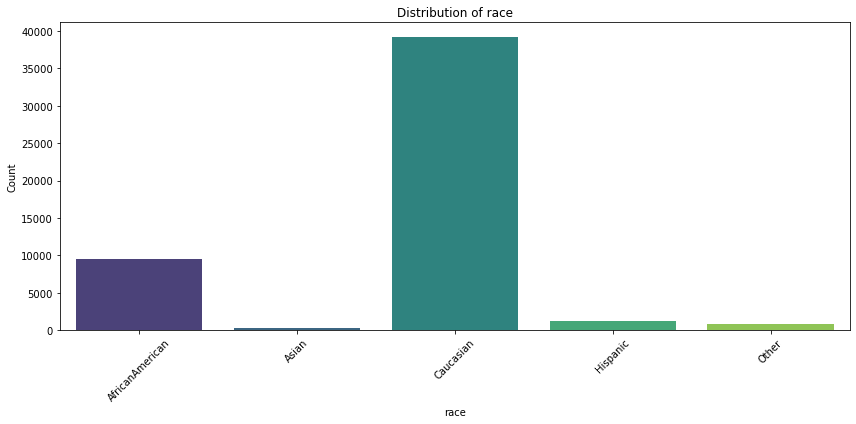

Visualizing Validation Set...
Visualizing distribution for age...


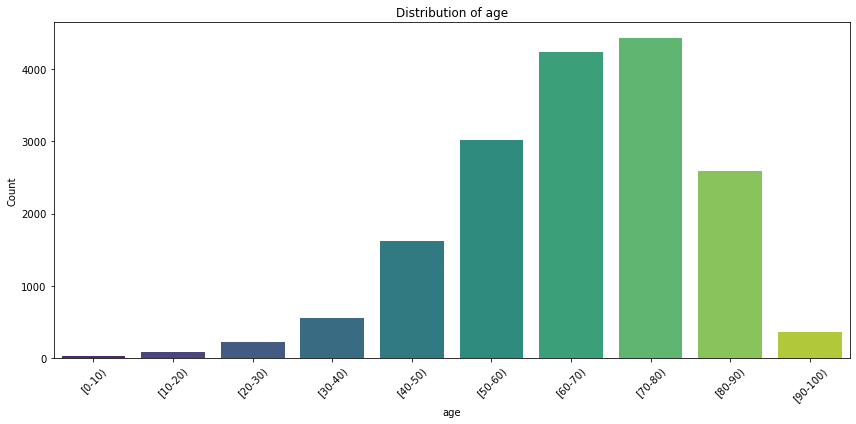

Visualizing distribution for gender...


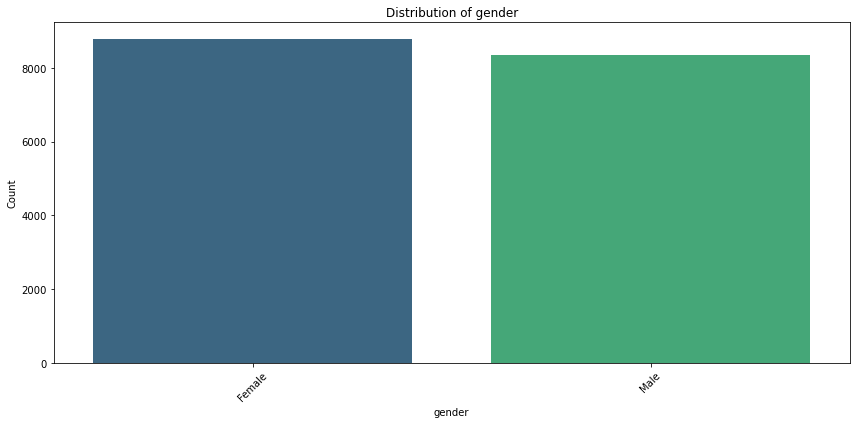

Visualizing distribution for race...


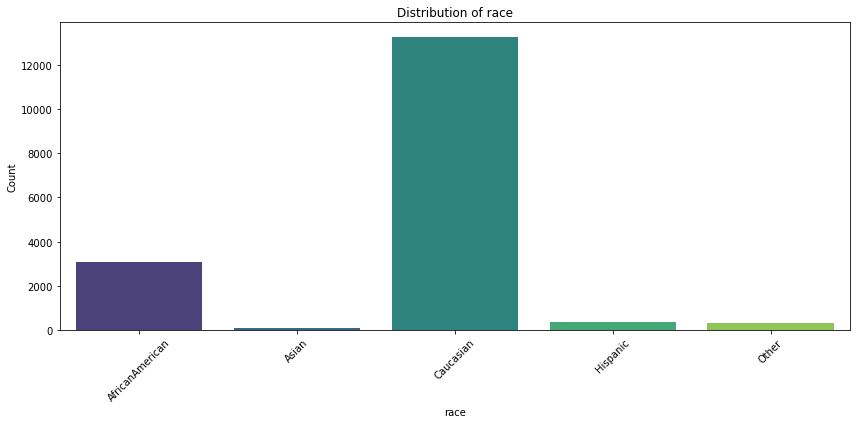

Visualizing Test Set...
Visualizing distribution for age...


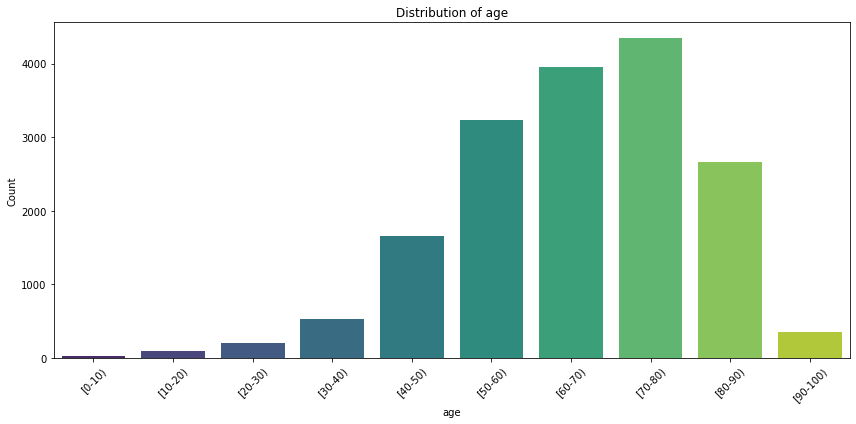

Visualizing distribution for gender...


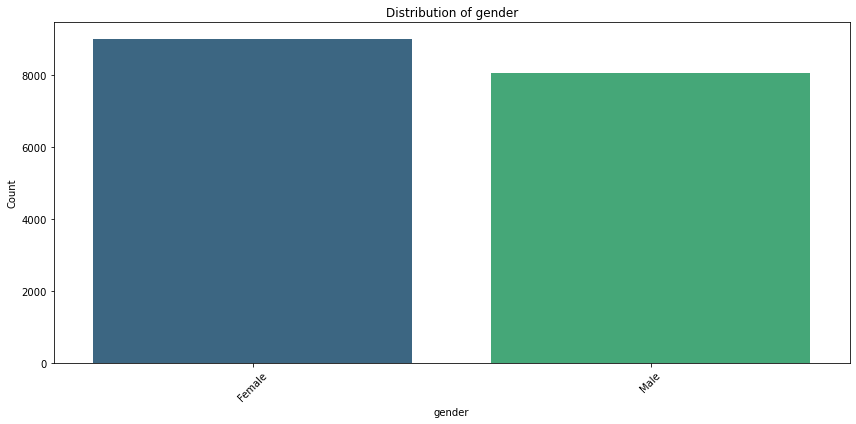

Visualizing distribution for race...


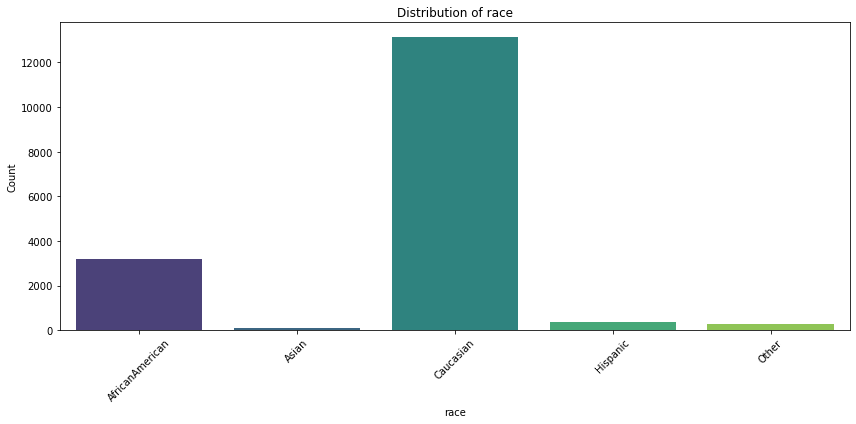

In [98]:
def visualize_distributions(df, group_columns, title_prefix=""):
    """
    Visualizes the distribution of key features across the DataFrame.

    Args:
    df (pandas.DataFrame): DataFrame to visualize.
    group_columns (list): List of columns to group and visualize.
    title_prefix (str): Prefix for the plot titles.
    """
    for column in group_columns:
        print(f"Visualizing distribution for {column}...")
        show_group_stats_viz(df, column)

# Define the key features/groups to analyze
key_features = ['age', 'gender', 'race']

# List of dataframes and their names to visualize
dfs = [train_df, val_df, test_df]
df_names = ['Training Set', 'Validation Set', 'Test Set']

# Visualize distributions for each partition
for df, name in zip(dfs, df_names):
    print(f"Visualizing {name}...")
    visualize_distributions(df, key_features)


In [102]:
def df_to_dataset(df, key_features, batch_size=128, shuffle=True):
    """
    Convert a pandas dataframe to a TensorFlow dataset.

    Args:
        df (pd.DataFrame): DataFrame to convert.
        key_features (str): Name of the predictor field.
        batch_size (int): Batch size for the dataset.
        shuffle (bool): Whether to shuffle the dataset.

    Returns:
        tf.data.Dataset: TensorFlow Dataset.
    """
    df = df.copy()
    # Convert pandas DataFrame to TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices(({
        col: df[col].values for col in df.columns if col != key_features
    }, df[key_features].values))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    
    dataset = dataset.batch(batch_size)
    return dataset


In [106]:
batch_size = 128

diabetes_train_ds = df_to_dataset(train_df, key_features, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(val_df, key_features, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(test_df, key_features, batch_size=batch_size)

# Sample a batch to verify
diabetes_batch = next(iter(diabetes_train_ds))



## Convert Dataset Splits to TF Dataset

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

## Create Categorical Features with Tensorflow Feature Column API

# 5. Create Numerical Features with TF Feature Columns

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

## Build Sequential API Model from DenseFeatures and TF Probability Layers

## Show Model Uncertainty Range with TF Probability

## Show Prediction Output 

## Convert Regression Output to Classification Output for Patient Selection

### Add Binary Prediction to Test Dataframe

## Model Evaluation Metrics 

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

## Reference Group Selection

## Race and Gender Bias Analysis for Patient Selection

## Fairness Analysis Example - Relative to a Reference Group 